# Consistency check 

## 1) Time To Coalescence

The time to coalescence for a given binary can be evaluated from the following formula:

$$t_c = \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df} df = \int_{r}^{r_{\mathrm{isco}}} \frac{dt}{dr} dr$$

In this notebook I will check the consistency between my version (numerical integration) and the one provided by pydd (analytical). I will also use Mathematica to independently check the analytical solution using the second expression for the time to coalescence and overplot the solutions to see which best matches.

## 2) Phase To Coalescence

The phase to coalescence for a given binary can be evaluated from the following formula:

$$\Phi_c = 2 \pi \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df} f df = 2 \pi \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{dr} \frac{dr}{df} f df$$

In this notebook I will check the consistency between my version (numerical integration) and the one provided by pydd (analytical). 

## 2) Double time Derivative of Phase To Coalescence

The second derivative of the phase to coalescence for a given binary can be evaluated from the following formula:

$$\Phi_c = 2 \pi \frac{df}{dt}$$

In this notebook I will check the consistency between my version and the one provided by pydd. 


### Note:

The following notebook will only consider the binary within an accretion disk, and not dark matter, or combined scenario cases.

### Import functions and stuff from pydd

In [111]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import interp1d
from pydd.analysis import calculate_SNR, calculate_match_unnormd_fft, get_match_pads, loglikelihood_fft, loglikelihood_fft_data, calculate_match_unnormd_fft_data
from pydd.binary import (
    AccretionDisk,
    MSUN,
    PC,
    Phi_to_c,
    get_c_f,
    get_m_2, 
    _Phi_to_c_indef,
    VacuumBinary,
    convert,
    get_M_chirp,
    get_f_isco,
    get_r_isco,
    get_f_range,
    get_m_1,
    make_vacuum_binary,
    t_to_c,
    YR,
    amp,
    d2Phi_dt2,
    G,
    C,
    Psi,
    restricted_hypgeom,
    h_0,
    _Phi_to_c_indef
)

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange
import corner

In [112]:
# Importing the functions from handy_functions.py and environments.py

import handy_functions
import environments
import importlib
importlib.reload(handy_functions)
importlib.reload(environments)

from environments import myVacuumBinary, myAccretionDisk

from handy_functions import df_dt_accretion, df_dt_gw, find_grid, time_to_coal
from handy_functions import hypgeom_scipy, hyp2f1_derivative, find_cf, phase_f
from handy_functions import f_1yr, h_0, mycalculate_SNR, amplitude, Psi

In [113]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "14"

### Select noise pattern

In [114]:
# Set detector
detector = "LISA"

In [115]:
# Set PSDs, choose observation time and SNR threshold (will set distance in signal system below)
if detector == "et":
    from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Einstein Telescope"
elif detector == "ce":
    from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Cosmic Explorer"
elif detector == "aLIGO":
    from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO

    T_OBS = 1 * YR 
    SNR_THRESH = 12.0
    TITLE = "aLIGO"
elif detector == "LISA":
    from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

    T_OBS = 1 * YR #seconds
    SNR_THRESH = 100.0
    TITLE = "LISA"

### My version of $\texttt{get_signal_system}$

In [116]:
def myget_signal_system() -> Tuple[myAccretionDisk, Tuple[float, float]]:
    """
    Creates an accretion disk with SNR and duration as set above for given detector.
    
    """
    m1 = 1e5 * MSUN # kg
    m2 = 10 * MSUN # kg
    r_s = 2 * G * m1/ C**2 # Schwartzschild radius of m1
    r0 = 3 * r_s
    Mach = 100 
    sigma0 = 1.5e10 / Mach**2
    alpha = -1/2
    
    _VB = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=100e6 * PC, 
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5))
    
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5)
    q = _VB.q
    
    TT_C = 0.0 # time of coalescence
    F_C = _VB.frequency(6 * G * m1 / C**2)
    PHI_C = 0.0 # phase at coalescence
    PN = 0 # zero means don't include PN effects
    
    _AD_D = myAccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=100e6 * PC,
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5))

    # Frequency range and grids
    F_RANGE_D = find_grid(_AD_D)
    FS = np.linspace(max(F_RANGE_D[0], f_range_n[0]), min(F_RANGE_D[1], f_range_n[1]), 50_000)
    #FS[-1] = F_RANGE_D[1]

    # Get dL such that SNR is as set above
    _fn = lambda dL: mycalculate_SNR(myAccretionDisk(mach=Mach, 
                                            m1=m1,
                                            m2=m2,
                                            r0=r0, 
                                            dist=dL,
                                            sigma0=sigma0, 
                                            alpha=alpha, 
                                            chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5)), FS, S_n)
    
    res = root_scalar(lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC))
    assert res.converged
    DL = res.root
    
    # Redefine AD and VB with "new" distance
    
    _AD_D_new = myAccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=DL,
    sigma0=sigma0, 
    alpha=alpha, 
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5))
    
    _VB_new = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=DL, 
    chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5))

    return _VB_new, _AD_D_new, F_RANGE_D

In [117]:
_VB, _AD_D, F_RANGE_D = myget_signal_system()

FS = np.linspace(F_RANGE_D[-1], F_RANGE_D[0], 10_000)  # coarser grid

### Pydd version of $\texttt{get_signal_system}$

In [118]:
def get_signal_system() -> Tuple[AccretionDisk, Tuple[float, float]]:
    """
    Creates an accretion disk with SNR and duration as set above for given detector.
    
    """
    M_1 = np.array(1e5 * MSUN) # kg
    M_2 = np.array(10 * MSUN) # kg
    M_CHIRP = get_M_chirp(M_1, M_2)
    Q = M_2 / M_1
    sigM2 = 1.58e10 # Sigma_0 * Mach^2 in kg/m^2
    TT_C = np.array(0.0) # time of coalescence
    F_C = get_f_isco(M_1)
    PHI_C = np.array(0.0) # phase at coalescence
    PN = 0 # zero means don't include PN effects
    _AD_D = AccretionDisk(PN,
        sigM2,
        -1, # torques act to speed up inspiral (choose 1 for opposite direction)
        get_M_chirp(M_1, M_2),
        M_2 / M_1,
        PHI_C,
        tT_c=TT_C,
        dL=np.array(100e6 * PC), # luminosity distance to source in metres, dummy fixed here
        f_c=get_f_isco(M_1),
    )

    # Frequency range and grids
    F_RANGE_D = get_f_range(_AD_D, T_OBS)
    FS = np.linspace(
        max(F_RANGE_D[0], f_range_n[0]), min(F_RANGE_D[1], f_range_n[1]), 50_000
    )

    # Get dL such that SNR is as set above
    _fn = lambda dL: calculate_SNR(
            AccretionDisk(_AD_D.PN,
                _AD_D.SigM2,
                _AD_D.inout,
                _AD_D.M_chirp,
                _AD_D.q,
                _AD_D.Phi_c,
                _AD_D.tT_c,
                dL,
                _AD_D.f_c,
            ),
            FS,
            S_n,
        )
    
    res = root_scalar(
        lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC)
    )
    assert res.converged
    DL = res.root

    # Signal system
    AD_D = AccretionDisk(_AD_D.PN,
        _AD_D.SigM2,
        _AD_D.inout,
        _AD_D.M_chirp,
        _AD_D.q,
        _AD_D.Phi_c,
        _AD_D.tT_c,
        DL,
        _AD_D.f_c,
    )

    return AD_D, F_RANGE_D

In [119]:
AD_D_pydd, F_RANGE_D_pydd = get_signal_system()

FS_pydd = np.linspace(F_RANGE_D_pydd[0], F_RANGE_D_pydd[-1], 10_000)  # coarser grid

# General Results

In [120]:
# Use same grid:

m1 = 1e5 * MSUN # kg
m2 = 10 * MSUN # kg
G = 6.67408e-11 # kg^-1 m^3 / s^2
c = 299792458.0 # m / s


f_LISA = 2e-3 # Hz
r_max_b = _AD_D.Binary_init.radius(f_LISA)

r_isco_b = 6 * m1 * G / c**2
f_isco_b = _AD_D.Binary_init.frequency(r_isco_b)

r_grid_b = np.linspace(r_isco_b, r_max_b, 100000)
freqs_b = _AD_D.Binary_init.frequency(r_grid_b)

print('radial separations: [', r_grid_b[0]/r_isco_b, ' ', r_grid_b[-1]/r_isco_b, '] r_isco')
print('frequency grid: [', freqs_b[0]/f_isco_b, ' ', freqs_b[-1]/f_isco_b, '] f_isco')

radial separations: [ 1.0   7.848128465549251 ] r_isco
frequency grid: [ 1.0   0.0454831824876235 ] f_isco


In [121]:
print('my ISCO from formula', FS[0])
print('pydd ISCO from formula', get_f_isco(m1))
print('Relative error (|mine - pydd|/pydd)', np.abs(FS[0] - get_f_isco(m1))/get_f_isco(m1) * 100, '%')

my ISCO from formula 0.043972296805401156
pydd ISCO from formula 0.04397009835544326
Relative error (|mine - pydd|/pydd) 0.0049998750062541985 %


In [122]:
print('my grid ISCO: ', FS[0])
print('pydd grid ISCO: ', FS_pydd[-1])
print('Relative error (|mine - pydd|/pydd)', np.abs(FS[0] - FS_pydd[-1])/FS_pydd[-1] * 100, '%')

my grid ISCO:  0.043972296805401156
pydd grid ISCO:  0.043970101520985884
Relative error (|mine - pydd|/pydd) 0.004992675339229774 %


In [123]:
print('my f_init: ', FS[-1])
print('pydd f_init: ', FS_pydd[0])
print('Relative error (|mine - pydd|/pydd)', np.abs(FS[-1] - FS_pydd[0])/FS_pydd[0] * 100, '%')

my f_init:  0.005511441473124048
pydd f_init:  0.005511598239489012
Relative error (|mine - pydd|/pydd) 0.0028442995688760233 %


# 1) Time To Coalescence

In [124]:
def _t_to_c_indef_a(f, params: AccretionDisk):# manual add and compare
    M1 = get_m_1(params.M_chirp, params.q)
    M2 = get_m_2(params.M_chirp, params.q)
    totm=M1 + M2
    return (-
        (C * M1**2 * (totm/G**2)**(
 1/3) * (-params.inout * 8 * np.log(f) + params.inout *  
   3 *np.log(
     128 *f**(8/3) * G * M1**3 * np.pi**(8/3) - params.inout *
      5 * np.sqrt(6) * C**4 * (G * totm**4)**(1/3) * params.SigM2))/(6 * np.sqrt(6) * M2 * (G * totm**4)**(
 1/3) * params.SigM2)
    )
    )

In [125]:
t_mine = -time_to_coal(freqs_b, _AD_D)
#t_pydd = t_to_c(freqs_b, AD_D_pydd) # not usable in this version

In [126]:
f_year = f_1yr(_AD_D) # estimate f 1yr from merger

In [127]:
from scipy.special import hyp2f1

def time_analytic(r, p: myAccretionDisk):
    
    '''Time to coalescence from analytical solution proided by Wolfram Mathematica.'''
    
    sigma0=p.sigma0
    r0=p.r0
    m1=p.Binary_init.m1
    m2=p.Binary_init.m2
    Mtot=p.Binary_init.M_tot
    q=p.Binary_init.q
    mach=p.mach
    pi=np.pi
    mu=p.Binary_init.mu
    
    numerator = mu * np.log(32 * G**3 * m1 * m2 * mu * Mtot + 5 * c**5 * mach**2 * (G * Mtot)**(1/2) * q**2 * r**4 * (r0)**(1/2) * sigma0)
    denominator = 8 * mach**2 * (G * Mtot)**(1/2) * q**2 * (r0)**(1/2) * sigma0
    
    result = - numerator/denominator 
        
    return result

In [128]:
time_manual_pydd = _t_to_c_indef_a(freqs_b, AD_D_pydd) - _t_to_c_indef_a(f_isco_b, AD_D_pydd)
time_wolfram = time_analytic(r_grid_b, _AD_D) - time_analytic(r_isco_b, _AD_D)

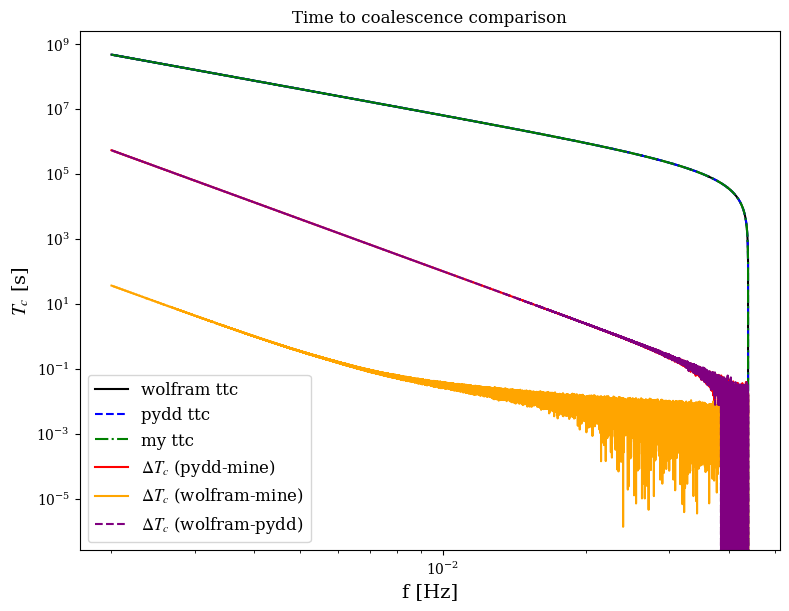

In [129]:
#fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.figure(figsize=(8, 6))

plt.loglog(freqs_b, -time_wolfram, label='wolfram ttc', c='black')
plt.loglog(freqs_b, time_manual_pydd, label='pydd ttc', linestyle='--', c='blue')
plt.loglog(freqs_b, t_mine, label='my ttc', linestyle='-.', c='green')
#plt.axvline(f_year, label='f_1yr', c='red', linestyle='-.')
plt.xlabel('f [Hz]')
plt.ylabel('$T_c$ [s]')

plt.loglog(freqs_b, np.abs(- t_mine + time_manual_pydd), label='$\Delta T_c$ (pydd-mine)', c='red')
plt.loglog(freqs_b, np.abs(t_mine + time_wolfram), label='$\Delta T_c$ (wolfram-mine)', c='orange')
plt.loglog(freqs_b, np.abs(time_manual_pydd + time_wolfram), label='$\Delta T_c$ (wolfram-pydd)', c='purple', linestyle='--')

plt.tight_layout()
plt.title('Time to coalescence comparison')
plt.legend(fontsize='large');

# 2) Phase To Coalescence

In [150]:
# for vacuum binary in pydd

VB_pydd = VacuumBinary(AD_D_pydd.PN,
        AD_D_pydd.M_chirp,
        AD_D_pydd.Phi_c,
        AD_D_pydd.tT_c,
        1.5151254848098492e+25, # from printing DL
        AD_D_pydd.f_c,
    )

In [131]:
# my version

phase_acc = phase_f(freqs_b, df_dt_accretion(freqs_b, _AD_D))
phase_gw = phase_f(freqs_b, df_dt_gw(freqs_b, _AD_D))

For the pydd version, since there is a mismatch in the f_isco I had to implement it "manually". You see the mismatch in the accretion disk.

In [152]:
def _Phi_to_c_indef_v(self, r):
    '''Compute indefinite phase to coalescence for vacuum.'''
    freqs = self.Binary_init.frequency(r)
    a_v = 1/16 * (c ** 3 / (np.pi * G * self.Binary_init.chirp_mass))**(5/3)
    return a_v / freqs**(5/3)
    
def _Phi_to_c_v(self, r):
    '''Compute phase to coalescence for vacuum.'''
    r_isco = 6 * self.Binary_init.m1 * G / c**2
    return _Phi_to_c_indef_v(self, r) -  _Phi_to_c_indef_v(self, r_isco)

In [153]:
# pydd version 

phase_acc_pydd = Phi_to_c(freqs_b[::-1], AD_D_pydd)
phase_gw_pydd = _Phi_to_c_v(_AD_D, r_grid_b)

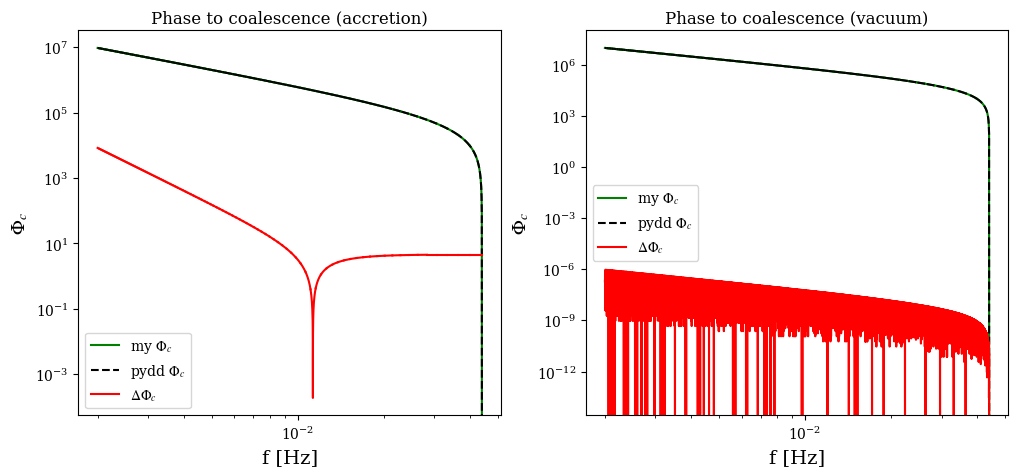

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].loglog(freqs_b, -phase_acc, c='green', label='my $\Phi_c$')
ax[0].loglog(freqs_b, phase_acc_pydd[::-1], c='black', linestyle='--', label='pydd $\Phi_c$')
ax[0].loglog(freqs_b, np.abs(phase_acc_pydd[::-1]+phase_acc), c='red', label='$\Delta\Phi_c$')
ax[0].legend()
ax[0].set_title('Phase to coalescence (accretion)')
ax[0].set_xlabel('f [Hz]')
ax[0].set_ylabel('$\Phi_c$');

ax[1].loglog(freqs_b, -phase_gw, c='green', label='my $\Phi_c$')
ax[1].loglog(freqs_b, phase_gw_pydd, c='black', linestyle='--', label='pydd $\Phi_c$')
ax[1].loglog(freqs_b, np.abs(phase_gw_pydd+phase_gw), c='red', label='$\Delta\Phi_c$')
ax[1].legend()
ax[1].set_title('Phase to coalescence (vacuum)')
ax[1].set_xlabel('f [Hz]')
ax[1].set_ylabel('$\Phi_c$');

# Additional check: Torque Units & Energy Loss

### Torque:

The units for the gas torque are (note that $q$ is a-dimensional, and $\mathcal{M}$ as well): 

$$[T_0] = [\frac{\mathrm{kg}}{\mathrm{m}^2}] \cdot [\mathrm{m}^4] \cdot [\frac{\mathrm{m}^3 \cdot \mathrm{kg}}{\mathrm{kg} \ \mathrm{s}^2 \cdot \mathrm{m}^3}] = [\frac{\mathrm{kg} \cdot \mathrm{m}^2}{\mathrm{s}^2}] = [\dot{L}]$$

In [134]:
# check units of masses: kg!

print('m1 ', _AD_D.Binary_init.m1)
print('m2 ', _AD_D.Binary_init.m2)
print('M_c ', _AD_D.Binary_init.chirp_mass)

m1  1.98855e+35
m2  1.98855e+31
M_c  7.91640181833791e+32


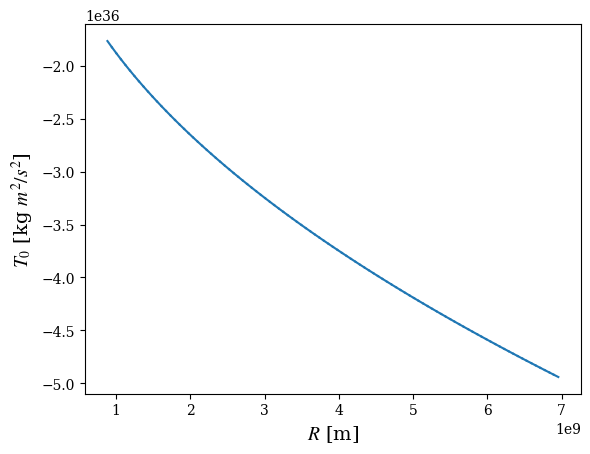

In [135]:
# first check the gas torque: 

gt = _AD_D.gas_torque(r_grid_b)

plt.plot(r_grid_b, gt)
plt.xlabel('$R$ [m]')
plt.ylabel('$T_0$ [kg $m^2/s^2$]');

### Energy loss:

For the energy loss we use the usual simple formula: 

$$\dot{E}_i = \frac{2 r^2}{G m_1 m_2} \dot{r}_i \ \text{with} \ \dot{r}_i < 0$$

In [136]:
def E_dot_acc(r, p: myAccretionDisk):
    
    '''Binary-in-accretion-disk energy loss.'''
     
    r_dot_acc = p.dot_r_acc(r)
    E_dot = G * p.Binary_init.m1 * p.Binary_init.m2 / (2 * r**2) * r_dot_acc
    
    return E_dot

def E_dot_GW(r, p: myAccretionDisk):
    
    '''Binary-in-vacuum energy loss.'''
     
    r_dot_GW = p.Binary_init.dot_r_gw(r)
    E_dot = G * p.Binary_init.m1 * p.Binary_init.m2 / (2 * r**2) * r_dot_GW
    
    return E_dot

In [137]:
E_dot_acc_i = E_dot_acc(r_grid_b, _AD_D)
E_dot_GW_i = E_dot_GW(r_grid_b, _AD_D)

In [138]:
# compare with plot from paper:

r_rs = [3.1429e+1, 4.0000e+1, 2.6190e+1, 2.2381e+1, 2.0000e+1, 1.7143e+1, 1.4286e+1,
1.5714e+1, 2.4286e+1, 2.9048e+1, 3.5714e+1]

e_dot_e = [1.0391e-2, 2.7123e-2, 5.0119e-3, 2.6102e-3, 1.7113e-3, 9.6235e-4, 4.2987e-4,
6.3096e-4, 3.6869e-3, 7.6442e-3,1.7783e-2]

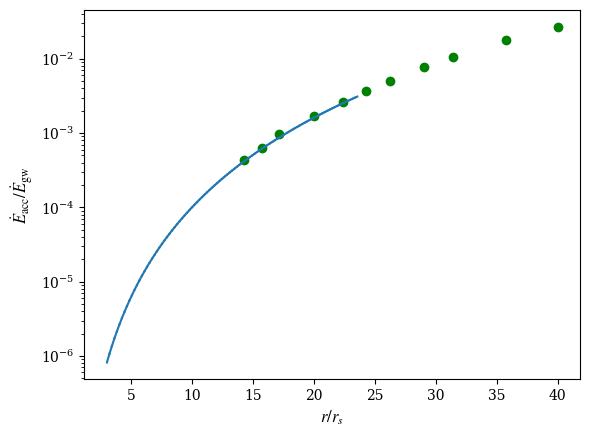

In [139]:
r_s = 2 * G * m1/ C**2 # Schwartzschild radius of m1
plt.semilogy(r_grid_b/r_s, E_dot_acc_i/E_dot_GW_i)
plt.scatter(r_rs, e_dot_e, c='green')
plt.yscale('log')
plt.xlabel('$r/r_s$', fontsize=12)
plt.ylabel('$\dot{E}_{\mathrm{acc}}/\dot{E}_{\mathrm{gw}}$', fontsize=12);